## Imports and Basic Setup
In this section, we import all required libraries and set up any
configuration needed for the notebook.


In [1]:
import re
import math
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Using device: cuda


## Utility Functions
Here, we define helper functions for:
1. Tokenizing sentences.
2. Building a vocabulary from the dataset.
3. Encoding tokens into integer IDs.


In [2]:
def simple_tokenize(sentence):
    sentence = sentence.lower()
    sentence = sentence.replace('<masked>', '[MASK]')
    tokens = re.findall(r"[A-Za-z]+|\[MASK\]|[^\w\s]", sentence)
    return tokens

def build_vocab(sentences, min_freq=1):
    counter = Counter()
    for s in sentences:
        tokens = simple_tokenize(s)
        counter.update(tokens)
    
    vocab = {
        '[PAD]': 0,
        '[UNK]': 1,
        '[CLS]': 2,
        '[SEP]': 3,
        '[MASK]': 4
    }
    idx = len(vocab)
    
    for token, freq in counter.items():
        if freq >= min_freq and token not in vocab:
            vocab[token] = idx
            idx += 1
    
    return vocab

def encode_tokens(tokens, vocab):
    return [vocab.get(t, vocab['[UNK]']) for t in tokens]


## Dataset Classes
- **MLMDataset**: For training. It randomly masks tokens in the input sentences.
- **MaskedTestDataset**: For inference. It expects already-masked sentences and returns them for prediction.


In [3]:
class MLMDataset(Dataset):
    def __init__(self, df, vocab, max_length=64, mask_prob=0.15):
        self.vocab = vocab
        self.max_length = max_length
        self.mask_prob = mask_prob
        
        self.samples = []
        for _, row in df.iterrows():
            text = row['SENTENCES']
            tokens = simple_tokenize(text)
            tokens = ['[CLS]'] + tokens + ['[SEP]']
            token_ids = encode_tokens(tokens, vocab)
            
            if len(token_ids) > max_length:
                token_ids = token_ids[:max_length]
            
            self.samples.append(token_ids)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        token_ids = self.samples[idx]
        if len(token_ids) < self.max_length:
            token_ids = token_ids + [self.vocab['[PAD]']] * (self.max_length - len(token_ids))
        
        input_ids = token_ids[:]
        labels = token_ids[:]
        
        for i in range(1, len(token_ids)-1):
            if token_ids[i] == self.vocab['[PAD]']:
                break 
            if random.random() < self.mask_prob:
                rand = random.random()
                if rand < 0.8:
                    input_ids[i] = self.vocab['[MASK]']
                elif rand < 0.9:
                    input_ids[i] = random.randint(0, len(self.vocab)-1)
                else:
                    pass
            else:
                labels[i] = -100
        
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long)
        }

class MaskedTestDataset(Dataset):
    def __init__(self, df, vocab, max_length=64):
        self.vocab = vocab
        self.max_length = max_length
        self.samples = []
        self.ids = []
        
        for _, row in df.iterrows():
            sent_id = row['IDS']
            text = row['MASKED SENTENCES']
            
            tokens = simple_tokenize(text)
            tokens = ['[CLS]'] + tokens + ['[SEP]']
            token_ids = encode_tokens(tokens, vocab)
            
            if len(token_ids) > max_length:
                token_ids = token_ids[:max_length]
            
            if len(token_ids) < max_length:
                token_ids += [vocab['[PAD]']] * (max_length - len(token_ids))
            
            self.samples.append(token_ids)
            self.ids.append(sent_id)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        token_ids = self.samples[idx]
        sent_id = self.ids[idx]
        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long)
        }, sent_id


## Model Components
We define a Transformer-based architecture similar to a small BERT:
1. **TransformerEmbedding** for token and positional embeddings.
2. **MultiHeadSelfAttention** for self-attention.
3. **TransformerEncoderBlock** containing attention + feed-forward.
4. **BERTEncoder** stacking multiple TransformerEncoderBlocks.
5. **MaskedLanguageModelHead** to produce vocabulary logits.
6. **BERTForMaskedLM** combining the encoder + MLM head.


In [4]:
class TransformerEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_length=512):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, embed_dim)
        self.pos_embed = nn.Embedding(max_length, embed_dim)
        self.register_buffer("position_ids", torch.arange(max_length).unsqueeze(0))

    def forward(self, input_ids):
        seq_len = input_ids.size(1)
        pos_ids = self.position_ids[:, :seq_len]
        
        token_embeddings = self.token_embed(input_ids)       
        position_embeddings = self.pos_embed(pos_ids)        
        
        return token_embeddings + position_embeddings


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        
        self.query = nn.Linear(embed_dim, embed_dim)
        self.key = nn.Linear(embed_dim, embed_dim)
        self.value = nn.Linear(embed_dim, embed_dim)
        self.out = nn.Linear(embed_dim, embed_dim)
    
    def forward(self, x, mask=None):
        bsz, seq_len, embed_dim = x.size()
        
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        
        Q = Q.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(bsz, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        scores = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self.head_dim)
        
        if mask is not None:
            expanded_mask = mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(expanded_mask == 0, float('-inf'))
        
        attn_weights = torch.softmax(scores, dim=-1)
        attn_output = torch.matmul(attn_weights, V)
        
        attn_output = attn_output.transpose(1, 2).contiguous()
        attn_output = attn_output.view(bsz, seq_len, embed_dim)
        
        output = self.out(attn_output)
        return output


class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_out = self.attn(x, mask=mask)
        x = self.norm1(x + self.dropout(attn_out))
        
        ff_out = self.ff(x)
        x = self.norm2(x + self.dropout(ff_out))
        return x


class BERTEncoder(nn.Module):
    def __init__(self, vocab_size, max_length=64, embed_dim=128, num_layers=2, num_heads=4, ff_dim=256, dropout=0.1):
        super().__init__()
        self.embedding = TransformerEmbedding(vocab_size, embed_dim, max_length=max_length)
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, num_heads, ff_dim, dropout) for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, input_ids, attention_mask=None):
        x = self.embedding(input_ids)  
        for layer in self.layers:
            x = layer(x, mask=attention_mask)
        x = self.norm(x)
        return x


class MaskedLanguageModelHead(nn.Module):
    def __init__(self, embed_dim, vocab_size):
        super().__init__()
        self.dense = nn.Linear(embed_dim, embed_dim)
        self.act = nn.GELU()
        self.layer_norm = nn.LayerNorm(embed_dim)
        self.classifier = nn.Linear(embed_dim, vocab_size)

    def forward(self, hidden_states):
        x = self.dense(hidden_states)
        x = self.act(x)
        x = self.layer_norm(x)
        logits = self.classifier(x)
        return logits


class BERTForMaskedLM(nn.Module):
    def __init__(self, vocab_size, max_length=64, embed_dim=128, num_layers=2, num_heads=4, ff_dim=256, dropout=0.1):
        super().__init__()
        self.encoder = BERTEncoder(
            vocab_size=vocab_size,
            max_length=max_length,
            embed_dim=embed_dim,
            num_layers=num_layers,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout=dropout
        )
        self.mlm_head = MaskedLanguageModelHead(embed_dim, vocab_size)

    def forward(self, input_ids, attention_mask=None):
        x = self.encoder(input_ids, attention_mask=attention_mask)  
        logits = self.mlm_head(x)                                   
        return logits


## Training and Validation
The function below:
- Trains the model for a specified number of epochs.
- Calculates the cross-entropy loss (ignoring positions that are not masked).
- Tracks the accuracy on masked positions.
- Returns training/validation loss and accuracy for each epoch.


In [5]:
def train_model_with_metrics(model, train_loader, val_loader, epochs=5, lr=1e-4, device='cuda'):
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        running_correct = 0
        running_total = 0
        
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            logits = model(input_ids)
            
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)), 
                labels.view(-1), 
                ignore_index=-100
            )
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
            with torch.no_grad():
                preds = logits.argmax(dim=-1)
                mask = (labels != -100)
                correct = (preds[mask] == labels[mask]).sum().item()
                total = mask.sum().item()
                running_correct += correct
                running_total += total
        
        train_avg_loss = total_loss / len(train_loader)
        train_accuracy = 100.0 * running_correct / running_total if running_total > 0 else 0.0
        
        train_losses.append(train_avg_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval()
        val_total_loss = 0
        val_running_correct = 0
        val_running_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                labels = batch['labels'].to(device)
                
                logits = model(input_ids)
                
                loss = F.cross_entropy(
                    logits.view(-1, logits.size(-1)), 
                    labels.view(-1), 
                    ignore_index=-100
                )
                
                val_total_loss += loss.item()
                
                preds = logits.argmax(dim=-1)
                mask = (labels != -100)
                correct = (preds[mask] == labels[mask]).sum().item()
                total = mask.sum().item()
                val_running_correct += correct
                val_running_total += total
        
        val_avg_loss = val_total_loss / len(val_loader)
        val_accuracy = 100.0 * val_running_correct / val_running_total if val_running_total > 0 else 0.0
        
        val_losses.append(val_avg_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"  Val Loss: {val_avg_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }


## Evaluation Metrics

In this project, we use two main metrics to evaluate our model’s performance on the Masked Language Modeling (MLM) task:

### 1. Cross-Entropy Loss
- **Definition**: We use the standard cross-entropy loss to measure the difference between the predicted probability distribution and the true distribution over vocabulary tokens.
- **Implementation Detail**: We set `ignore_index=-100` for non-masked tokens, so the model is only penalized for incorrect predictions at masked positions.
- **Rationale**: Cross-entropy is a natural choice for classification tasks (predicting the correct token out of the entire vocabulary). Ignoring non-masked tokens focuses the loss on the positions we actually want to predict.

### 2. Masked Accuracy
- **Definition**: This metric calculates how often the model’s predicted token (via `argmax`) matches the ground-truth token at masked positions.
  $$
\text{masked\_accuracy} = \frac{\text{number of correct predictions on masked tokens}}{\text{total masked tokens}}
$$

- **Rationale**: Masked accuracy directly reflects our primary objective: to fill in the correct missing word for each masked position. Hence, it gives a clear, interpretable measure of the model’s ability to predict missing words.

By combining **Cross-Entropy Loss** (which the model optimizes during training) and **Masked Accuracy** (which gives an intuitive measure of predictive performance), we gain a comprehensive view of how well the model learns to fill in masked tokens.


## Plotting Training and Validation Metrics
This function plots the training/validation loss and accuracy over epochs.


In [6]:
def plot_metrics(metrics):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(metrics['train_losses'], label='Train Loss')
    plt.plot(metrics['val_losses'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(metrics['train_accuracies'], label='Train Accuracy')
    plt.plot(metrics['val_accuracies'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()


## Inference Functions
1. **predict_masked_tokens**: Given an input with `[MASK]` tokens, predicts the missing tokens.
2. **run_inference**: Runs the model on the entire test dataset and writes predictions to a CSV.



In [7]:
def predict_masked_tokens(model, input_ids, vocab, device='cuda'):
    model.eval()
    input_ids = input_ids.to(device)
    
    with torch.no_grad():
        logits = model(input_ids)  
    
    logits = logits[0]  
    
    mask_id = vocab['[MASK]']
    mask_positions = (input_ids[0] == mask_id).nonzero(as_tuple=True)[0].tolist()
    
    inv_vocab = {idx: tok for tok, idx in vocab.items()}
    predictions = []
    for pos in mask_positions:
        mask_logits = logits[pos]   
        pred_id = mask_logits.argmax(dim=-1).item()
        pred_token = inv_vocab[pred_id]
        predictions.append((pos, pred_token))
    
    return predictions


def run_inference(model, test_loader, vocab, output_file="sample_submission.csv", device='cuda'):
    inv_vocab = {idx: tok for tok, idx in vocab.items()}
    results = []
    
    model.eval()
    with torch.no_grad():
        for batch, sent_id in test_loader:
            input_ids = batch['input_ids'].to(device)  
            
            preds = predict_masked_tokens(model, input_ids, vocab, device=device)
            
            if len(preds) > 0:
                predicted_word = preds[0][1]
            else:
                predicted_word = "[NO_MASK_FOUND]"
            
            results.append((sent_id, predicted_word))
    
    df_out = pd.DataFrame(results, columns=["IDS", "PREDICTED WORDS"])
    df_out.to_csv(output_file, index=False)
    print(f"Saved predictions to {output_file}")


## Main Execution
Finally, we define the `main()` function to:
1. Load the training data.
2. Build the vocabulary.
3. Create train/validation datasets and loaders.
4. Instantiate and train the model.
5. Plot the metrics.
6. Load test data and run inference.
7. Save the final predictions to a CSV file.


Using device: cuda
Train set size: 50000
Vocab size: 43884
Training samples: 45000, Validation samples: 5000
Epoch 1/8
  Train Loss: 0.2186, Train Accuracy: 97.44%
  Val Loss: 0.1944, Val Accuracy: 97.62%
Epoch 2/8
  Train Loss: 0.1912, Train Accuracy: 97.62%
  Val Loss: 0.1887, Val Accuracy: 97.68%
Epoch 3/8
  Train Loss: 0.1840, Train Accuracy: 97.68%
  Val Loss: 0.1799, Val Accuracy: 97.75%
Epoch 4/8
  Train Loss: 0.1805, Train Accuracy: 97.70%
  Val Loss: 0.1763, Val Accuracy: 97.75%
Epoch 5/8
  Train Loss: 0.1757, Train Accuracy: 97.74%
  Val Loss: 0.1759, Val Accuracy: 97.78%
Epoch 6/8
  Train Loss: 0.1726, Train Accuracy: 97.77%
  Val Loss: 0.1783, Val Accuracy: 97.74%
Epoch 7/8
  Train Loss: 0.1690, Train Accuracy: 97.80%
  Val Loss: 0.1715, Val Accuracy: 97.81%
Epoch 8/8
  Train Loss: 0.1691, Train Accuracy: 97.79%
  Val Loss: 0.1731, Val Accuracy: 97.79%


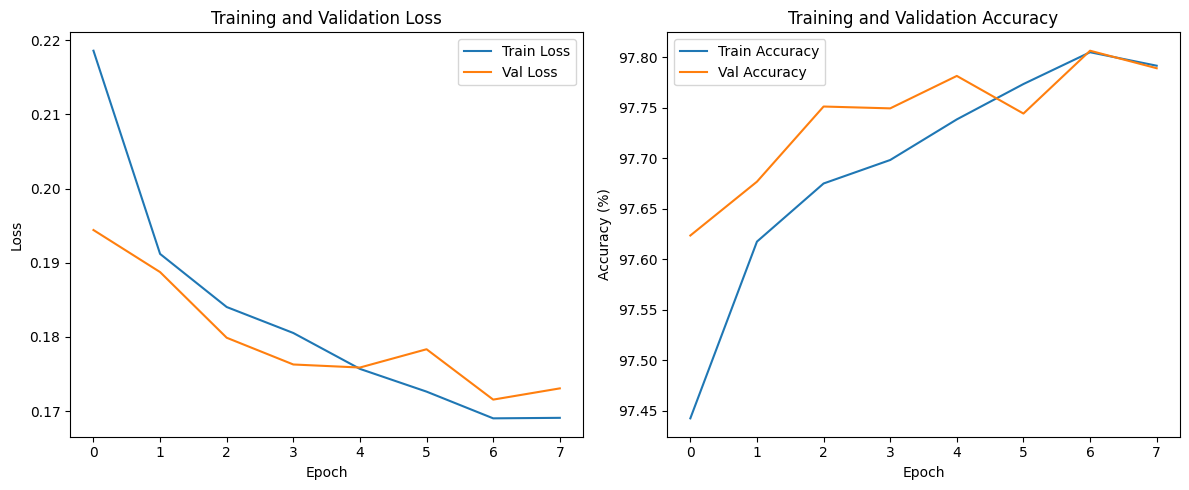

Model checkpoint saved as model_checkpoint.pth
Test set size: 10000
Saved predictions to sample_submission.csv


In [8]:
def main():
    global device
    print(f"Using device: {device}")
    
    train_df = pd.read_csv("/kaggle/input/masked-word-prediction/train_set_f.csv")  
    print("Train set size:", len(train_df))
    
    train_sentences = train_df['SENTENCES'].tolist()
    vocab = build_vocab(train_sentences, min_freq=1)
    print("Vocab size:", len(vocab))
    
    full_dataset = MLMDataset(train_df, vocab, max_length=64, mask_prob=0.15)
    
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
    
    print(f"Training samples: {train_size}, Validation samples: {val_size}")
    
    model = BERTForMaskedLM(
        vocab_size=len(vocab),
        max_length=64,
        embed_dim=512,
        num_layers=6,
        num_heads=8,
        ff_dim=1024,
        dropout=0.1
    )
    
    metrics = train_model_with_metrics(
        model, 
        train_loader, 
        val_loader, 
        epochs=8, 
        lr=1e-4, 
        device=device
    )
    
    plot_metrics(metrics)

    torch.save(model.state_dict(), "model_checkpoint.pth")
    print("Model checkpoint saved as model_checkpoint.pth")
    
    test_df = pd.read_csv("/kaggle/input/masked-word-prediction/test_set_f.csv")  
    print("Test set size:", len(test_df))
    
    test_dataset = MaskedTestDataset(test_df, vocab, max_length=64)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    
    run_inference(model, test_loader, vocab, output_file="sample_submission.csv", device=device)


if __name__ == "__main__":
    main()
